In [32]:
# Add scripts to path and fix working directory
import sys
import os
from pathlib import Path

# Set project root explicitly
project_root = Path(__file__).parent.parent.parent if '__file__' in locals() else Path("/home/Plutonium/Documents/BioinfoMidterm")

os.chdir(project_root)
sys.path.insert(0, str(project_root / "scripts"))

print(f"Working directory: {os.getcwd()}")

# Import config module and set population FIRST
import config as cfg
cfg.set_population_config("sea_jpt_cn")

# Now create aliases (pointing to updated config)
PATHS = cfg.PATHS
ML = cfg.ML
POPULATIONS = cfg.POPULATIONS

# Import other modules
from utils import (
    vcf_to_numeric_matrix,
    add_population_labels,
    ensure_dir,
    run_bcftools_command,
    variants_to_bed_file,
)
from ml_training import (
    load_ml_data,
    train_random_forest,
    train_xgboost,
    train_logistic_regression,
    evaluate_model,
    cross_validate_model,
    get_feature_importances,
    train_on_top_features,
    save_model,
    run_full_pipeline,
)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Configuration
print("\nML Configuration:")
print(f"  Test size: {ML.TEST_SIZE}")
print(f"  Random state: {ML.RANDOM_STATE}")
print(f"  RF estimators: {ML.RF_N_ESTIMATORS}")
print(f"  XGB estimators: {ML.XGB_N_ESTIMATORS}")
print(f"  Top N features: {ML.TOP_N_FEATURES}")

Working directory: /home/Plutonium/Documents/BioinfoMidterm

ML Configuration:
  Test size: 0.2
  Random state: 42
  RF estimators: 200
  XGB estimators: 200
  Top N features: 25


## Step 1: Prepare ML Data

Check if ML data exists. If not, run VCF conversion pipeline to create it.

In [33]:
# Check if ML data exists
import os

ML_DATA_PATH = str(PATHS.ML_DATA)

if os.path.exists(ML_DATA_PATH):
    print(f"✓ ML data exists: {ML_DATA_PATH}")
    NEED_VCF_CONVERSION = False
else:
    print("✗ ML data not found. Will run VCF conversion steps.")
    NEED_VCF_CONVERSION = True

✓ ML data exists: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv


## Step 1a: VCF to Numeric Conversion (if needed)

This section converts VCF data to a numeric genotype matrix suitable for ML.

**Pipeline:**
1. Extract selected SNPs from VCF using BED coordinates
2. Filter to biallelic SNPs only
3. Convert genotypes to numeric (0/1/2)
4. Transpose so samples are rows
5. Add population labels

In [34]:
# Step 1: Extract SNPs from VCF using BED file
if NEED_VCF_CONVERSION:
    from utils import run_bcftools_command, variants_to_bed_file
    
    # Paths
    TOP_SNPS_FILE = str(PATHS.TOP_SNPS_FILE)
    TOP_SNPS_BED = str(PATHS.TOP_SNPS_BED)
    VCF_FILE = str(PATHS.VCF_FILE)
    FILTERED_VCF = str(PATHS.VCF_DIR / "filtered.vcf.gz")
    SAMPLES_LIST = str(PATHS.EAS_SAMPLES_LIST)
    
    # Convert SNP IDs to BED format (if not exists)
    if not os.path.exists(TOP_SNPS_BED):
        print("Converting SNP IDs to BED format...")
        variants_to_bed_file(TOP_SNPS_FILE, TOP_SNPS_BED)
    else:
        print(f"✓ BED file exists: {TOP_SNPS_BED}")
    
    # Extract SNPs from VCF
    print("\nExtracting SNPs from VCF...")
    run_bcftools_command([
        "view",
        "-S", SAMPLES_LIST,
        "-R", TOP_SNPS_BED,
        "-Oz",
        "-o", FILTERED_VCF,
        VCF_FILE
    ])
    print(f"✓ Created filtered VCF: {FILTERED_VCF}")
else:
    print("Skipping VCF extraction - ML data already exists.")

Skipping VCF extraction - ML data already exists.


In [35]:
# Step 2: Filter to biallelic SNPs only
if NEED_VCF_CONVERSION:
    FILTERED_VCF = str(PATHS.VCF_DIR / "filtered.vcf.gz")
    SNPS_ONLY_VCF = str(PATHS.VCF_DIR / "filtered_snps_only.vcf")
    SNPS_FINAL_VCF = str(PATHS.VCF_DIR / "filtered_snps_only_final.vcf")
    
    print("Filtering to biallelic SNPs only...")
    
    # Filter ALT to single nucleotide
    run_bcftools_command([
        "view",
        "-i", 'ALT ~ "^[ATGC]$"',
        "-o", SNPS_ONLY_VCF,
        FILTERED_VCF
    ])
    
    # Filter REF to single nucleotide
    run_bcftools_command([
        "view",
        "-i", 'REF ~ "^[ATGC]$"',
        "-o", SNPS_FINAL_VCF,
        SNPS_ONLY_VCF
    ])
    
    print(f"✓ Created biallelic SNP VCF: {SNPS_FINAL_VCF}")
else:
    print("Skipping SNP filtering - ML data already exists.")

Skipping SNP filtering - ML data already exists.


In [36]:
# Step 3: Clean VCF (remove ## header lines) and convert to numeric matrix
if NEED_VCF_CONVERSION:
    SNPS_FINAL_VCF = str(PATHS.VCF_DIR / "filtered_snps_only_final.vcf")
    CLEAN_VCF = str(PATHS.VCF_DIR / "snps_only_clean.vcf")
    NUMERIC_CSV = str(PATHS.VCF_DIR / "vcf_numeric_transposed.csv")
    
    # Remove ## meta lines, keep #CHROM header and data
    print("Cleaning VCF headers...")
    with open(SNPS_FINAL_VCF, 'r') as fin, open(CLEAN_VCF, 'w') as fout:
        for line in fin:
            if not line.startswith('##'):
                fout.write(line)
    print(f"✓ Created clean VCF: {CLEAN_VCF}")
    
    # Convert to numeric matrix using utility function
    print("\nConverting VCF to numeric matrix...")
    numeric_df = vcf_to_numeric_matrix(CLEAN_VCF, NUMERIC_CSV, verbose=True)
else:
    print("Skipping VCF cleaning - ML data already exists.")

Skipping VCF cleaning - ML data already exists.


In [37]:
# Step 4: Add population labels
if NEED_VCF_CONVERSION:
    NUMERIC_CSV = str(PATHS.VCF_DIR / "vcf_numeric_transposed.csv")
    POPULATION_CSV = str(PATHS.EAS_SAMPLES_CSV)
    ML_DATA_OUTPUT = str(PATHS.ML_DATA)
    
    print("Adding population labels...")
    final_df = add_population_labels(NUMERIC_CSV, POPULATION_CSV, ML_DATA_OUTPUT, verbose=True)
    
    print(f"\n✓ ML data created successfully!")
    print(f"  Output: {ML_DATA_OUTPUT}")
    print(f"  Shape: {final_df.shape}")
    print(f"  Populations: {final_df['pop'].value_counts().to_dict()}")
    
    # Update path for downstream steps
    ML_DATA_PATH = ML_DATA_OUTPUT
else:
    print("Skipping population labeling - ML data already exists.")

Skipping population labeling - ML data already exists.


## Step 1b: Load ML Data

Load the prepared numeric matrix with population labels.

In [38]:
# Load ML data
X, y, feature_names = load_ml_data(
    ML_DATA_PATH,
    target_column="pop",
    verbose=True,
)

print(f"\nFeature matrix shape: {X.shape}")
print(f"Target distribution:")
print(y.value_counts())

Loading data from: 1000genomes/vcf_sea_jpt_cn/vcf_numeric_transposed_with_population.csv


  Samples: 504
  Features: 2518
  Classes: 3 ({'CN': 208, 'SEA': 192, 'JPT': 104})

Feature matrix shape: (504, 2518)
Target distribution:
pop
CN     208
SEA    192
JPT    104
Name: count, dtype: int64


In [39]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Classes: {le.classes_}")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=ML.TEST_SIZE,
    stratify=y,
    random_state=ML.RANDOM_STATE,
)

y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

print(f"\nTrain set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")

Classes: ['CN' 'JPT' 'SEA']

Train set: 403 samples
Test set: 101 samples


## Step 2: Train Random Forest

In [40]:
# Train Random Forest
rf = train_random_forest(
    X_train, y_train,
    n_estimators=ML.RF_N_ESTIMATORS,
    verbose=True,
)


Training Random Forest...
  n_estimators: 200
  max_depth: None
  Training complete!


In [41]:
# Evaluate Random Forest
rf_results = evaluate_model(rf, X_test, y_test, "Random Forest", verbose=True)


Random Forest EVALUATION
Accuracy: 0.9802
F1 (macro): 0.9833
F1 (weighted): 0.9802

Classification Report:
              precision    recall  f1-score   support

          CN       1.00      0.95      0.98        42
         JPT       1.00      1.00      1.00        21
         SEA       0.95      1.00      0.97        38

    accuracy                           0.98       101
   macro avg       0.98      0.98      0.98       101
weighted avg       0.98      0.98      0.98       101



In [42]:
# Cross-validation
from sklearn.ensemble import RandomForestClassifier

rf_cv = cross_validate_model(
    RandomForestClassifier(n_estimators=ML.RF_N_ESTIMATORS, random_state=ML.RANDOM_STATE),
    X, y,
    cv=ML.CV_FOLDS,
    model_name="Random Forest",
)


Cross-validating Random Forest (5-fold)...
  CV Accuracy: 0.9583 (+/- 0.0556)


## Step 3: Train XGBoost

In [43]:
# Train XGBoost
try:
    xgb_clf = train_xgboost(
        X_train, y_train_encoded,
        n_estimators=ML.XGB_N_ESTIMATORS,
        max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE,
        verbose=True,
    )
    
    # Evaluate
    xgb_results = evaluate_model(xgb_clf, X_test, y_test_encoded, "XGBoost", verbose=True)
except ImportError as e:
    print(f"XGBoost not available: {e}")
    xgb_clf = None


Training XGBoost...
  n_estimators: 200
  max_depth: 6
  learning_rate: 0.1


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:55:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  Training complete!

XGBoost EVALUATION
Accuracy: 0.9703
F1 (macro): 0.9713
F1 (weighted): 0.9703

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.95      0.96        42
           1       1.00      0.95      0.98        21
           2       0.95      1.00      0.97        38

    accuracy                           0.97       101
   macro avg       0.98      0.97      0.97       101
weighted avg       0.97      0.97      0.97       101



## Step 4: Train Logistic Regression

In [44]:
# Train Logistic Regression
lr = train_logistic_regression(
    X_train, y_train,
    max_iter=ML.LR_MAX_ITER,
    verbose=True,
)

# Evaluate
lr_results = evaluate_model(lr, X_test, y_test, "Logistic Regression", verbose=True)


Training Logistic Regression...
  max_iter: 1000
  solver: lbfgs


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Training complete!

Logistic Regression EVALUATION
Accuracy: 1.0000
F1 (macro): 1.0000
F1 (weighted): 1.0000

Classification Report:
              precision    recall  f1-score   support

          CN       1.00      1.00      1.00        42
         JPT       1.00      1.00      1.00        21
         SEA       1.00      1.00      1.00        38

    accuracy                           1.00       101
   macro avg       1.00      1.00      1.00       101
weighted avg       1.00      1.00      1.00       101



## Step 5: Compare Models

In [45]:
# Collect results
results = {
    "Random Forest": rf_results,
    "Logistic Regression": lr_results,
}
if xgb_clf is not None:
    results["XGBoost"] = xgb_results

# Comparison table
comparison_df = pd.DataFrame({
    "Model": results.keys(),
    "Accuracy": [r["accuracy"] for r in results.values()],
    "F1 (macro)": [r["f1_macro"] for r in results.values()],
    "F1 (weighted)": [r["f1_weighted"] for r in results.values()],
})

print("Model Comparison:")
display(comparison_df)

Model Comparison:


,Model,Accuracy,F1 (macro),F1 (weighted)
0,Random Forest,0.980198,0.983323,0.980210
1,Logistic Regression,1.000000,1.000000,1.000000
2,XGBoost,0.970297,0.971275,0.970251


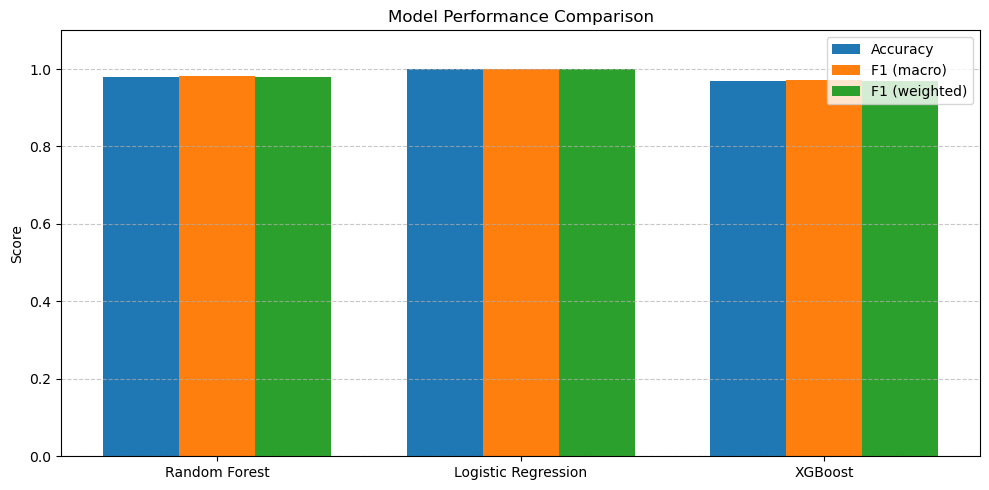

In [46]:
# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(comparison_df))
width = 0.25

ax.bar(x - width, comparison_df["Accuracy"], width, label="Accuracy")
ax.bar(x, comparison_df["F1 (macro)"], width, label="F1 (macro)")
ax.bar(x + width, comparison_df["F1 (weighted)"], width, label="F1 (weighted)")

ax.set_ylabel("Score")
ax.set_title("Model Performance Comparison")
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["Model"])
ax.legend()
ax.set_ylim(0, 1.1)
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Step 6: Confusion Matrices

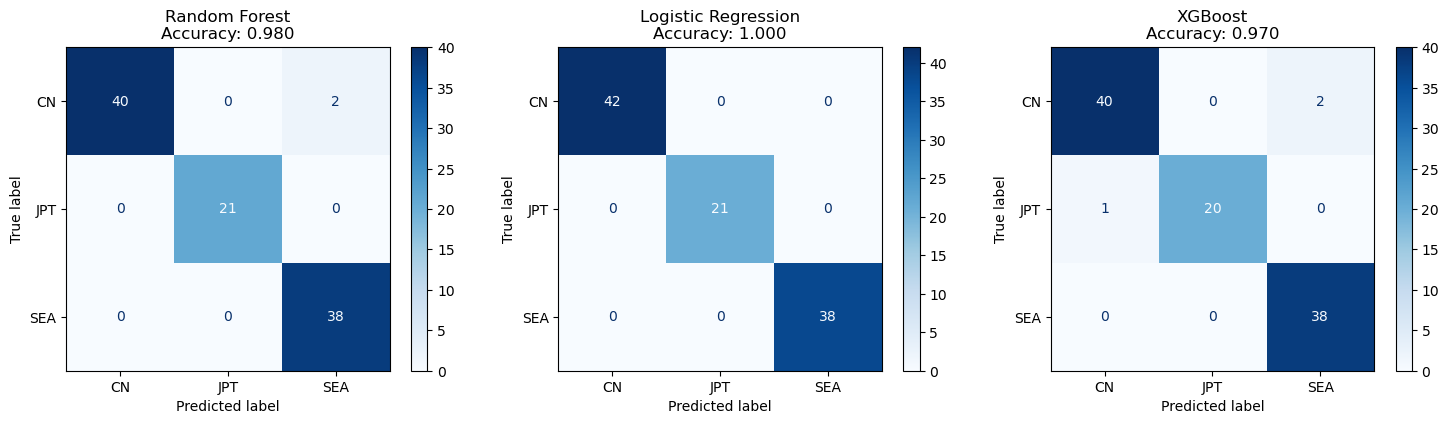

In [47]:
# Plot confusion matrices
fig, axes = plt.subplots(1, len(results), figsize=(5*len(results), 4))

if len(results) == 1:
    axes = [axes]

for ax, (name, result) in zip(axes, results.items()):
    ConfusionMatrixDisplay(
        result["confusion_matrix"],
        display_labels=le.classes_,
    ).plot(ax=ax, cmap="Blues")
    ax.set_title(f"{name}\nAccuracy: {result['accuracy']:.3f}")

plt.tight_layout()
plt.show()

## Step 7: Feature Importance Analysis

In [48]:
# Get feature importances from Random Forest
rf_importance = get_feature_importances(
    rf, feature_names,
    top_n=ML.TOP_N_FEATURES,
    verbose=True,
)


Top 25 Features by Importance:
  1:12387655: 0.011238
  3:152553769: 0.010802
  4:17813761: 0.009931
  19:54792079: 0.008571
  14:96938945: 0.008308
  3:86028382: 0.008068
  6:82912256: 0.006744
  9:37486004: 0.006534
  9:98231346: 0.006479
  16:33974960: 0.005293
  21:38533017: 0.004946
  5:41181491: 0.004766
  10:134188783: 0.004662
  1:22315762: 0.004484
  12:4388084: 0.004472
  16:67913222: 0.004432
  6:152588967: 0.004400
  14:96755874: 0.004270
  10:31138896: 0.004136
  18:18518431: 0.003687
  1:33070778: 0.003634
  11:112053732: 0.003580
  1:102457870: 0.003393
  9:133578385: 0.003243
  6:170619277: 0.003167


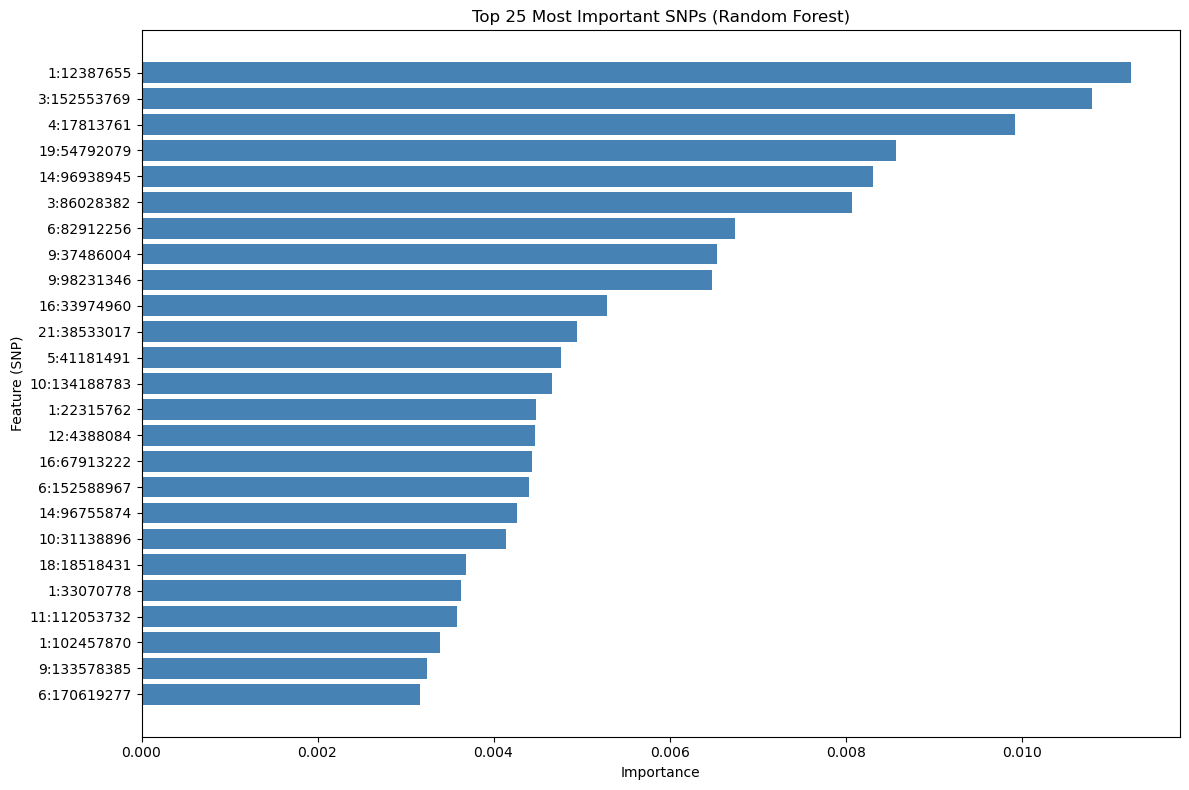

In [49]:
# Visualize top features
top_n = ML.TOP_N_FEATURES
top_features = rf_importance.head(top_n)

plt.figure(figsize=(12, 8))
plt.barh(range(top_n), top_features['importance'].values[::-1], color='steelblue')
plt.yticks(range(top_n), top_features['feature'].values[::-1])
plt.xlabel('Importance')
plt.ylabel('Feature (SNP)')
plt.title(f'Top {top_n} Most Important SNPs (Random Forest)')
plt.tight_layout()
plt.show()

## Step 8: Train on Top Features Only

In [50]:
# Train on top features
from sklearn.ensemble import RandomForestClassifier

rf_top, rf_top_results = train_on_top_features(
    RandomForestClassifier,
    X, y,
    rf_importance,
    top_n=ML.TOP_N_FEATURES,
    test_size=ML.TEST_SIZE,
    random_state=ML.RANDOM_STATE,
    n_estimators=ML.RF_N_ESTIMATORS,
)


Training on top 25 features...

RandomForestClassifier (top 25) EVALUATION
Accuracy: 0.8614
F1 (macro): 0.8521
F1 (weighted): 0.8601

Classification Report:
              precision    recall  f1-score   support

          CN       0.90      0.86      0.88        42
         JPT       0.94      0.71      0.81        21
         SEA       0.80      0.95      0.87        38

    accuracy                           0.86       101
   macro avg       0.88      0.84      0.85       101
weighted avg       0.87      0.86      0.86       101



In [51]:
# Compare full vs top features
print("\nPerformance Comparison:")
print("="*60)
print(f"Full features ({len(feature_names)}):")
print(f"  Accuracy: {rf_results['accuracy']:.4f}")
print(f"  F1 (macro): {rf_results['f1_macro']:.4f}")
print(f"\nTop {ML.TOP_N_FEATURES} features:")
print(f"  Accuracy: {rf_top_results['accuracy']:.4f}")
print(f"  F1 (macro): {rf_top_results['f1_macro']:.4f}")


Performance Comparison:
Full features (2518):
  Accuracy: 0.9802
  F1 (macro): 0.9833

Top 25 features:
  Accuracy: 0.8614
  F1 (macro): 0.8521


### Train Multiple Models on Top Features

Compare different classifiers using only the top SNP features to find the best model for this reduced feature set.

In [52]:
# Prepare top features data
top_feature_names = rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()
X_top = X[top_feature_names]

# Split with top features only
X_train_top, X_test_top, y_train_top, y_test_top = train_test_split(
    X_top, y,
    test_size=ML.TEST_SIZE,
    stratify=y,
    random_state=ML.RANDOM_STATE,
)

y_train_top_encoded = le.transform(y_train_top)
y_test_top_encoded = le.transform(y_test_top)

print(f"Top {ML.TOP_N_FEATURES} Features Dataset:")
print(f"  Train: {X_train_top.shape}")
print(f"  Test: {X_test_top.shape}")
print(f"  Features: {top_feature_names[:5]}...")

Top 25 Features Dataset:
  Train: (403, 25)
  Test: (101, 25)
  Features: ['1:12387655', '3:152553769', '4:17813761', '19:54792079', '14:96938945']...


In [53]:
# Train multiple models on top features
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
import xgboost as xgb

# Define models to compare
top_feature_models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=ML.RF_N_ESTIMATORS, 
        random_state=ML.RANDOM_STATE,
        n_jobs=-1
    ),
    'XGBoost': xgb.XGBClassifier(
        n_estimators=ML.XGB_N_ESTIMATORS,
        max_depth=ML.XGB_MAX_DEPTH,
        learning_rate=ML.XGB_LEARNING_RATE,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=ML.RANDOM_STATE,
        n_jobs=-1
    ),
    'Logistic Regression': LogisticRegression(
        max_iter=ML.LR_MAX_ITER,
        multi_class='multinomial',
        solver='lbfgs',
        random_state=ML.RANDOM_STATE,
        n_jobs=-1
    ),
    'SVM (RBF)': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=ML.RANDOM_STATE
    ),
    'SVM (Linear)': SVC(
        kernel='linear',
        C=1.0,
        random_state=ML.RANDOM_STATE
    ),
    'K-Nearest Neighbors': KNeighborsClassifier(
        n_neighbors=5,
        n_jobs=-1
    ),
    'Naive Bayes': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=ML.RANDOM_STATE
    ),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=100,
        learning_rate=0.1,
        random_state=ML.RANDOM_STATE
    ),
    'MLP Neural Net': MLPClassifier(
        hidden_layer_sizes=(100, 50),
        max_iter=500,
        random_state=ML.RANDOM_STATE,
        early_stopping=True
    ),
}

print(f"Training {len(top_feature_models)} models on top {ML.TOP_N_FEATURES} features...")
print("="*60)

Training 10 models on top 25 features...


In [54]:
# Train and evaluate all models
top_feature_results = {}

for model_name, model in top_feature_models.items():
    print(f"\n>>> Training {model_name}...")
    
    # XGBoost and MLP need encoded labels
    if 'XGBoost' in model_name or 'MLP' in model_name:
        model.fit(X_train_top, y_train_top_encoded)
        y_pred = model.predict(X_test_top)
        acc = accuracy_score(y_test_top_encoded, y_pred)
        f1 = f1_score(y_test_top_encoded, y_pred, average='macro')
        f1_weighted = f1_score(y_test_top_encoded, y_pred, average='weighted')
        cm = confusion_matrix(y_test_top_encoded, y_pred)
    else:
        model.fit(X_train_top, y_train_top)
        y_pred = model.predict(X_test_top)
        acc = accuracy_score(y_test_top, y_pred)
        f1 = f1_score(y_test_top, y_pred, average='macro')
        f1_weighted = f1_score(y_test_top, y_pred, average='weighted')
        cm = confusion_matrix(y_test_top, y_pred)
    
    top_feature_results[model_name] = {
        'model': model,
        'accuracy': acc,
        'f1_macro': f1,
        'f1_weighted': f1_weighted,
        'y_pred': y_pred,
        'confusion_matrix': cm,
    }
    
    print(f"    Accuracy: {acc:.4f}")
    print(f"    F1 (macro): {f1:.4f}")

print("\n" + "="*60)
print("Training complete!")


>>> Training Random Forest...
    Accuracy: 0.8614
    F1 (macro): 0.8543

>>> Training XGBoost...
    Accuracy: 0.8515
    F1 (macro): 0.8427

>>> Training Logistic Regression...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/xgboost/training.py:199: UserWarning: [16:56:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1764148544963/work/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


    Accuracy: 0.8317
    F1 (macro): 0.8144

>>> Training SVM (RBF)...
    Accuracy: 0.8515
    F1 (macro): 0.8401

>>> Training SVM (Linear)...
    Accuracy: 0.8119
    F1 (macro): 0.8006

>>> Training K-Nearest Neighbors...
    Accuracy: 0.7921
    F1 (macro): 0.7388

>>> Training Naive Bayes...
    Accuracy: 0.7525
    F1 (macro): 0.7446

>>> Training Gradient Boosting...
    Accuracy: 0.8614
    F1 (macro): 0.8543

>>> Training AdaBoost...
    Accuracy: 0.7822
    F1 (macro): 0.7567

>>> Training MLP Neural Net...
    Accuracy: 0.8020
    F1 (macro): 0.7679

Training complete!


In [55]:
# Results comparison table
results_df = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': r['accuracy'],
        'F1 (macro)': r['f1_macro'],
        'F1 (weighted)': r['f1_weighted'],
    }
    for name, r in top_feature_results.items()
]).sort_values('Accuracy', ascending=False)

print(f"\nModel Comparison on Top {ML.TOP_N_FEATURES} Features:")
print("="*70)
display(results_df.reset_index(drop=True))

# Best model
best_top_model = results_df.iloc[0]
print(f"\n🏆 Best Model: {best_top_model['Model']}")
print(f"   Accuracy: {best_top_model['Accuracy']:.4f}")
print(f"   F1 (macro): {best_top_model['F1 (macro)']:.4f}")


Model Comparison on Top 25 Features:


,Model,Accuracy,F1 (macro),F1 (weighted)
0,Random Forest,0.861386,0.854253,0.860326
1,Gradient Boosting,0.861386,0.854253,0.860326
2,XGBoost,0.851485,0.842683,0.850157
3,SVM (RBF),0.851485,0.840142,0.849061
4,Logistic Regression,0.831683,0.814408,0.827479
5,SVM (Linear),0.811881,0.800569,0.811273
6,MLP Neural Net,0.801980,0.767939,0.793097
7,K-Nearest Neighbors,0.792079,0.738751,0.773209
8,AdaBoost,0.782178,0.756662,0.776176
9,Naive Bayes,0.752475,0.744550,0.754708



🏆 Best Model: Random Forest
   Accuracy: 0.8614
   F1 (macro): 0.8543


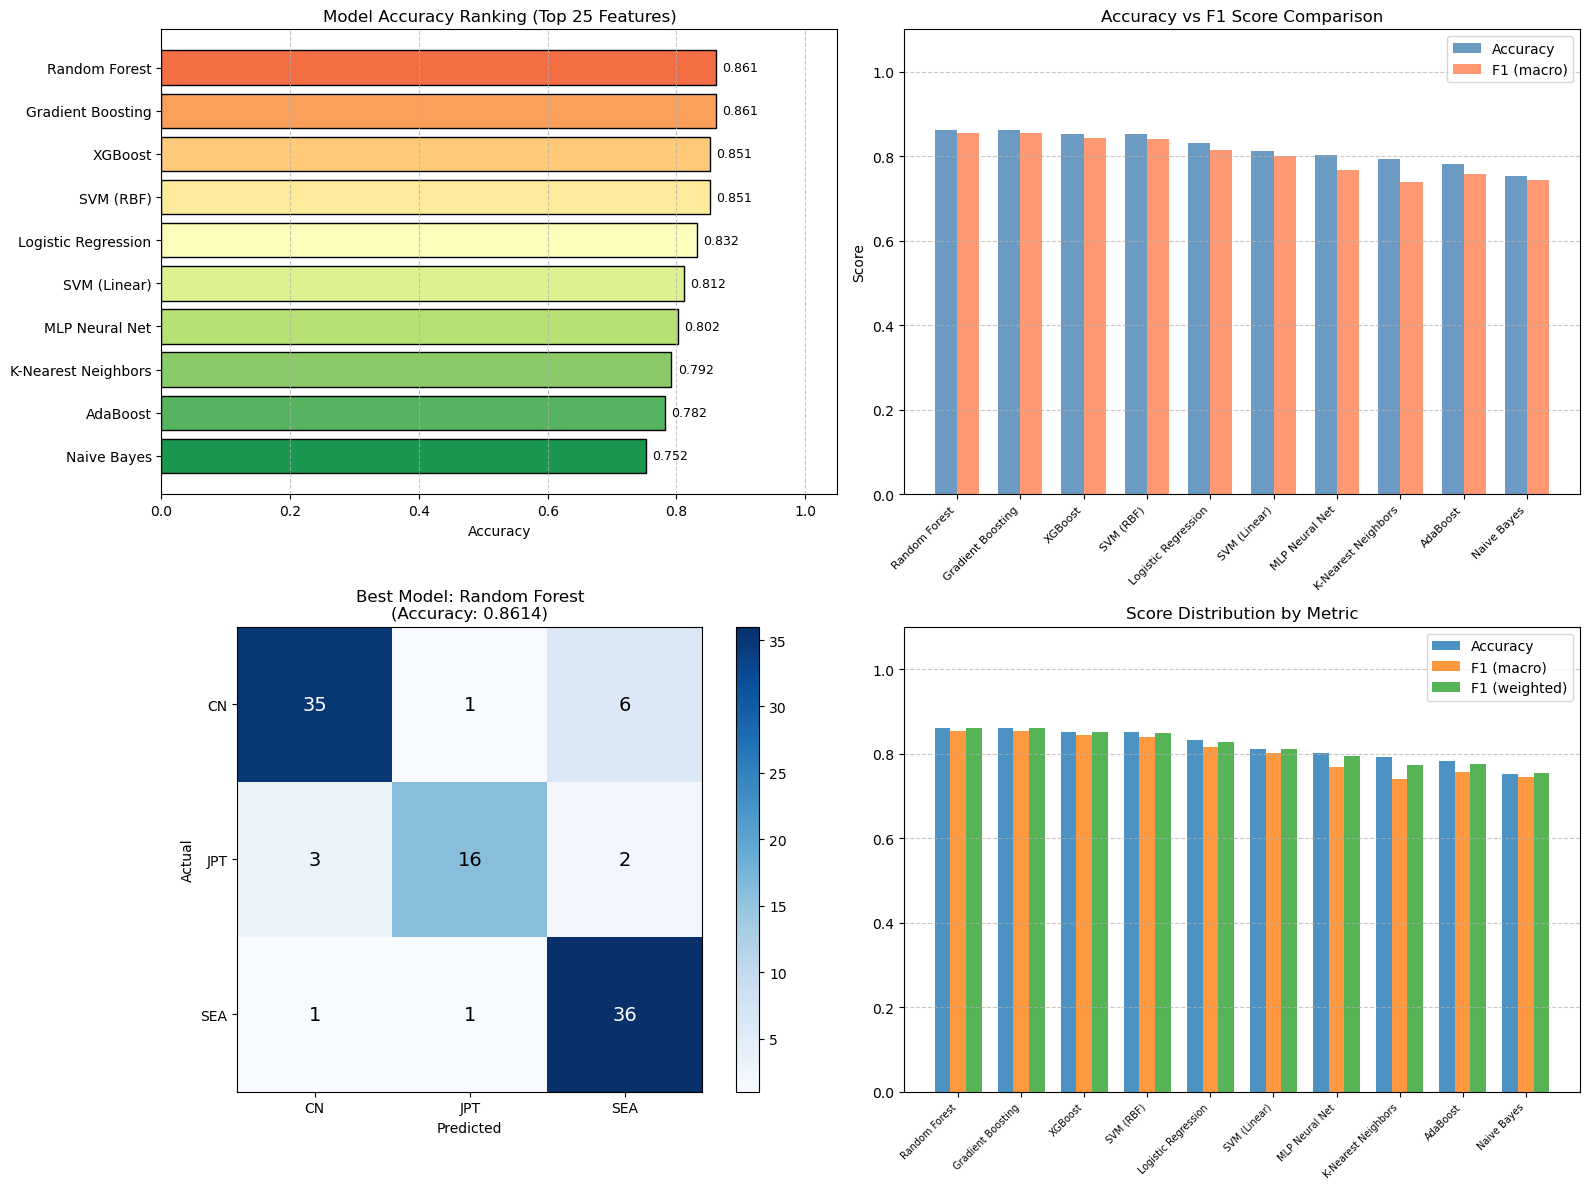

In [56]:
# Visualize model comparison on top features
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Sort by accuracy for plotting
sorted_results = sorted(top_feature_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names_sorted = [m[0] for m in sorted_results]
accuracies_sorted = [m[1]['accuracy'] for m in sorted_results]
f1_sorted = [m[1]['f1_macro'] for m in sorted_results]

# Plot 1: Horizontal bar chart - Accuracy ranking
colors = plt.cm.RdYlGn(np.linspace(0.2, 0.9, len(sorted_results)))
bars = axes[0, 0].barh(model_names_sorted[::-1], accuracies_sorted[::-1], color=colors[::-1], edgecolor='black')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title(f'Model Accuracy Ranking (Top {ML.TOP_N_FEATURES} Features)')
axes[0, 0].set_xlim(0, 1.05)
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for bar, acc in zip(bars, accuracies_sorted[::-1]):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{acc:.3f}', ha='left', va='center', fontsize=9)

# Plot 2: Grouped bar chart - Accuracy vs F1
x_pos = np.arange(len(model_names_sorted))
width = 0.35
axes[0, 1].bar(x_pos - width/2, accuracies_sorted, width, label='Accuracy', color='steelblue', alpha=0.8)
axes[0, 1].bar(x_pos + width/2, f1_sorted, width, label='F1 (macro)', color='coral', alpha=0.8)
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Accuracy vs F1 Score Comparison')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(model_names_sorted, rotation=45, ha='right', fontsize=8)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1.1)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Confusion matrices for top 3 models (as subplots)
top_3_models = sorted_results[:3]
for idx, (name, result) in enumerate(top_3_models):
    if idx == 0:
        ax_cm = axes[1, 0]
    elif idx == 1:
        # Create inset for 2nd best
        continue
    elif idx == 2:
        continue
    
    cm = result['confusion_matrix']
    im = ax_cm.imshow(cm, cmap='Blues')
    ax_cm.set_title(f'Best Model: {name}\n(Accuracy: {result["accuracy"]:.4f})')
    ax_cm.set_xlabel('Predicted')
    ax_cm.set_ylabel('Actual')
    ax_cm.set_xticks(range(len(le.classes_)))
    ax_cm.set_yticks(range(len(le.classes_)))
    ax_cm.set_xticklabels(le.classes_)
    ax_cm.set_yticklabels(le.classes_)
    for i in range(len(le.classes_)):
        for j in range(len(le.classes_)):
            ax_cm.text(j, i, cm[i, j], ha='center', va='center',
                      color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=14)
    plt.colorbar(im, ax=ax_cm)

# Plot 4: Box plot of scores
scores_data = []
for name in model_names_sorted:
    r = top_feature_results[name]
    scores_data.append({
        'Model': name,
        'Metric': 'Accuracy',
        'Score': r['accuracy']
    })
    scores_data.append({
        'Model': name,
        'Metric': 'F1 (macro)',
        'Score': r['f1_macro']
    })
    scores_data.append({
        'Model': name,
        'Metric': 'F1 (weighted)',
        'Score': r['f1_weighted']
    })

scores_df = pd.DataFrame(scores_data)
axes[1, 1].set_title('Score Distribution by Metric')

# Create grouped bars manually
metrics = ['Accuracy', 'F1 (macro)', 'F1 (weighted)']
x = np.arange(len(model_names_sorted))
width = 0.25
for i, metric in enumerate(metrics):
    values = [top_feature_results[m][['accuracy', 'f1_macro', 'f1_weighted'][i]] for m in model_names_sorted]
    axes[1, 1].bar(x + i*width - width, values, width, label=metric, alpha=0.8)

axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names_sorted, rotation=45, ha='right', fontsize=7)
axes[1, 1].legend()
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

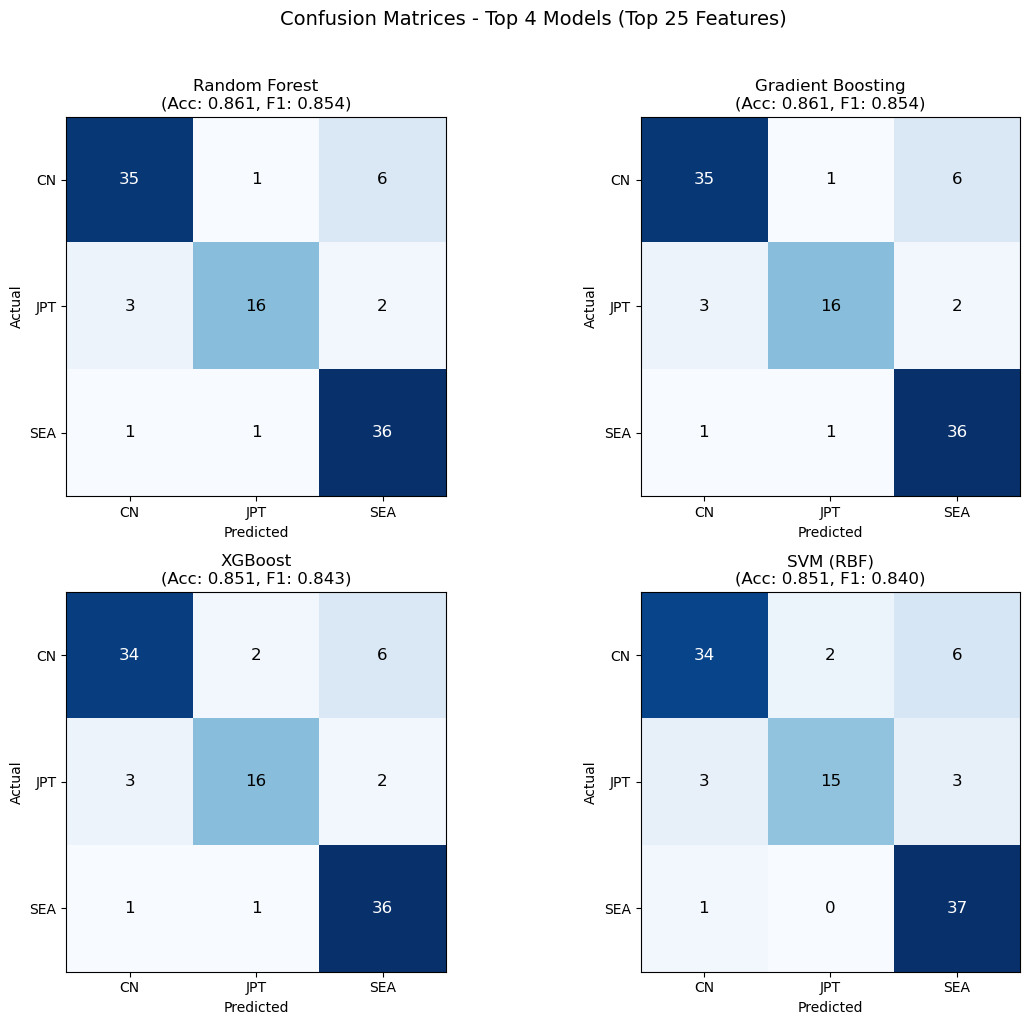

In [57]:
# Display confusion matrices for top 4 models
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

top_4_models = sorted_results[:4]

for idx, (name, result) in enumerate(top_4_models):
    cm = result['confusion_matrix']
    im = axes[idx].imshow(cm, cmap='Blues')
    axes[idx].set_title(f'{name}\n(Acc: {result["accuracy"]:.3f}, F1: {result["f1_macro"]:.3f})')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_xticks(range(len(le.classes_)))
    axes[idx].set_yticks(range(len(le.classes_)))
    axes[idx].set_xticklabels(le.classes_)
    axes[idx].set_yticklabels(le.classes_)
    for i in range(len(le.classes_)):
        for j in range(len(le.classes_)):
            axes[idx].text(j, i, cm[i, j], ha='center', va='center',
                          color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=12)

plt.suptitle(f'Confusion Matrices - Top 4 Models (Top {ML.TOP_N_FEATURES} Features)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

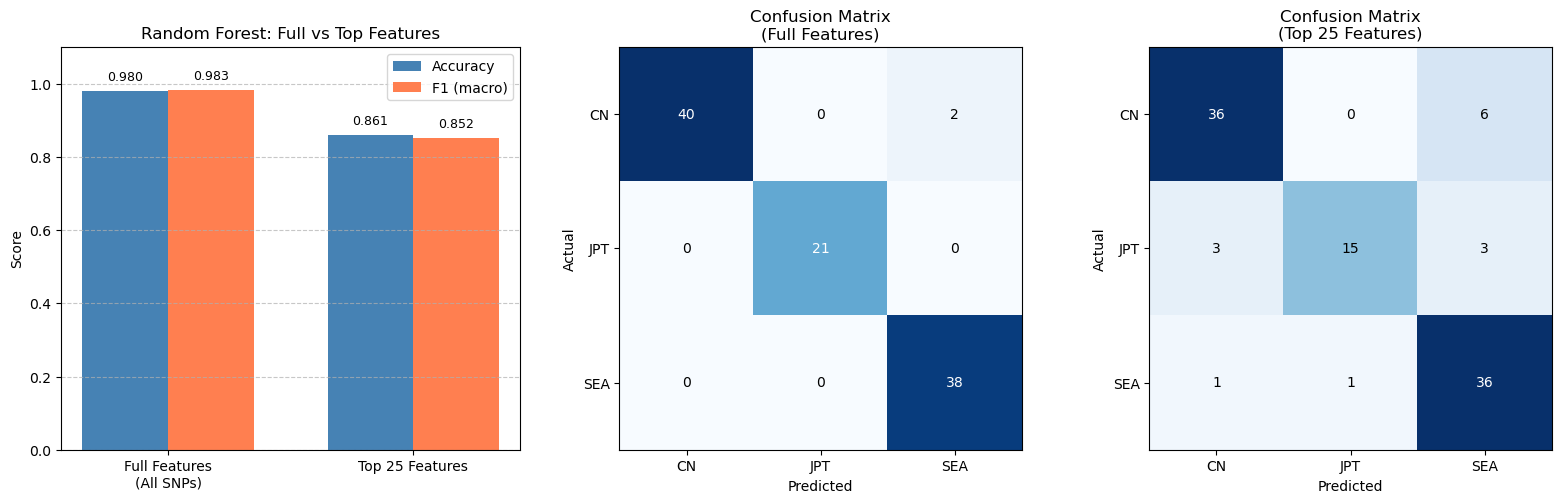

In [58]:
# Visualize Full vs Top Features Performance Comparison
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Bar chart: Accuracy comparison
models = ['Full Features\n(All SNPs)', f'Top {ML.TOP_N_FEATURES} Features']
accuracies = [rf_results['accuracy'], rf_top_results['accuracy']]
f1_scores = [rf_results['f1_macro'], rf_top_results['f1_macro']]

x_pos = np.arange(len(models))
width = 0.35

axes[0].bar(x_pos - width/2, accuracies, width, label='Accuracy', color='steelblue')
axes[0].bar(x_pos + width/2, f1_scores, width, label='F1 (macro)', color='coral')
axes[0].set_ylabel('Score')
axes[0].set_title('Random Forest: Full vs Top Features')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(models)
axes[0].legend()
axes[0].set_ylim(0, 1.1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels
for i, (acc, f1) in enumerate(zip(accuracies, f1_scores)):
    axes[0].text(i - width/2, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, f1 + 0.02, f'{f1:.3f}', ha='center', va='bottom', fontsize=9)

# Confusion matrix for full features
from sklearn.metrics import confusion_matrix
y_pred_full = rf.predict(X_test)
cm_full = confusion_matrix(y_test, y_pred_full)
im1 = axes[1].imshow(cm_full, cmap='Blues')
axes[1].set_title('Confusion Matrix\n(Full Features)')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_xticks(range(len(le.classes_)))
axes[1].set_yticks(range(len(le.classes_)))
axes[1].set_xticklabels(le.classes_)
axes[1].set_yticklabels(le.classes_)
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        axes[1].text(j, i, cm_full[i, j], ha='center', va='center', 
                    color='white' if cm_full[i, j] > cm_full.max()/2 else 'black')

# Confusion matrix for top features
X_top = X[rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()]
X_test_top = X_test[rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()]
y_pred_top = rf_top.predict(X_test_top)
cm_top = confusion_matrix(y_test, y_pred_top)
im2 = axes[2].imshow(cm_top, cmap='Blues')
axes[2].set_title(f'Confusion Matrix\n(Top {ML.TOP_N_FEATURES} Features)')
axes[2].set_xlabel('Predicted')
axes[2].set_ylabel('Actual')
axes[2].set_xticks(range(len(le.classes_)))
axes[2].set_yticks(range(len(le.classes_)))
axes[2].set_xticklabels(le.classes_)
axes[2].set_yticklabels(le.classes_)
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        axes[2].text(j, i, cm_top[i, j], ha='center', va='center',
                    color='white' if cm_top[i, j] > cm_top.max()/2 else 'black')

plt.tight_layout()
plt.show()

## Step 8a: TabPFN Model Comparison

TabPFN is a transformer-based model that performs well on small tabular datasets without hyperparameter tuning. It's particularly suited for datasets with:
- ≤1000 training samples
- ≤100 features
- ≤10 classes

In [59]:
# Train TabPFN on top features (TabPFN works best with ≤100 features)
try:
    from tabpfn import TabPFNClassifier
    
    # Use top features for TabPFN (it has feature limit)
    X_top_features = rf_importance.head(ML.TOP_N_FEATURES)['feature'].tolist()
    X_train_top = X_train[X_top_features]
    X_test_top = X_test[X_top_features]
    
    print(f"Training TabPFN on top {ML.TOP_N_FEATURES} features...")
    print(f"Train shape: {X_train_top.shape}, Test shape: {X_test_top.shape}")
    
    # Initialize and train TabPFN
    tabpfn = TabPFNClassifier(device='cpu', n_estimators=4)
    tabpfn.fit(X_train_top.values, y_train_encoded)
    
    # Predict
    y_pred_tabpfn = tabpfn.predict(X_test_top.values)
    
    # Evaluate
    from sklearn.metrics import accuracy_score, f1_score, classification_report
    tabpfn_accuracy = accuracy_score(y_test_encoded, y_pred_tabpfn)
    tabpfn_f1 = f1_score(y_test_encoded, y_pred_tabpfn, average='macro')
    
    print(f"\nTabPFN Results:")
    print(f"  Accuracy: {tabpfn_accuracy:.4f}")
    print(f"  F1 (macro): {tabpfn_f1:.4f}")
    print(f"\nClassification Report:")
    print(classification_report(y_test_encoded, y_pred_tabpfn, target_names=le.classes_))
    
    tabpfn_results = {
        'accuracy': tabpfn_accuracy,
        'f1_macro': tabpfn_f1,
        'y_pred': y_pred_tabpfn,
    }
    TABPFN_AVAILABLE = True
    
except ImportError as e:
    print(f"TabPFN not installed. Install with: pip install tabpfn")
    print(f"Error: {e}")
    TABPFN_AVAILABLE = False
except Exception as e:
    print(f"TabPFN error: {e}")
    TABPFN_AVAILABLE = False

Training TabPFN on top 25 features...
Train shape: (403, 25), Test shape: (101, 25)


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(



TabPFN Results:
  Accuracy: 0.8614
  F1 (macro): 0.8543

Classification Report:
              precision    recall  f1-score   support

          CN       0.90      0.83      0.86        42
         JPT       0.89      0.76      0.82        21
         SEA       0.82      0.95      0.88        38

    accuracy                           0.86       101
   macro avg       0.87      0.85      0.85       101
weighted avg       0.87      0.86      0.86       101



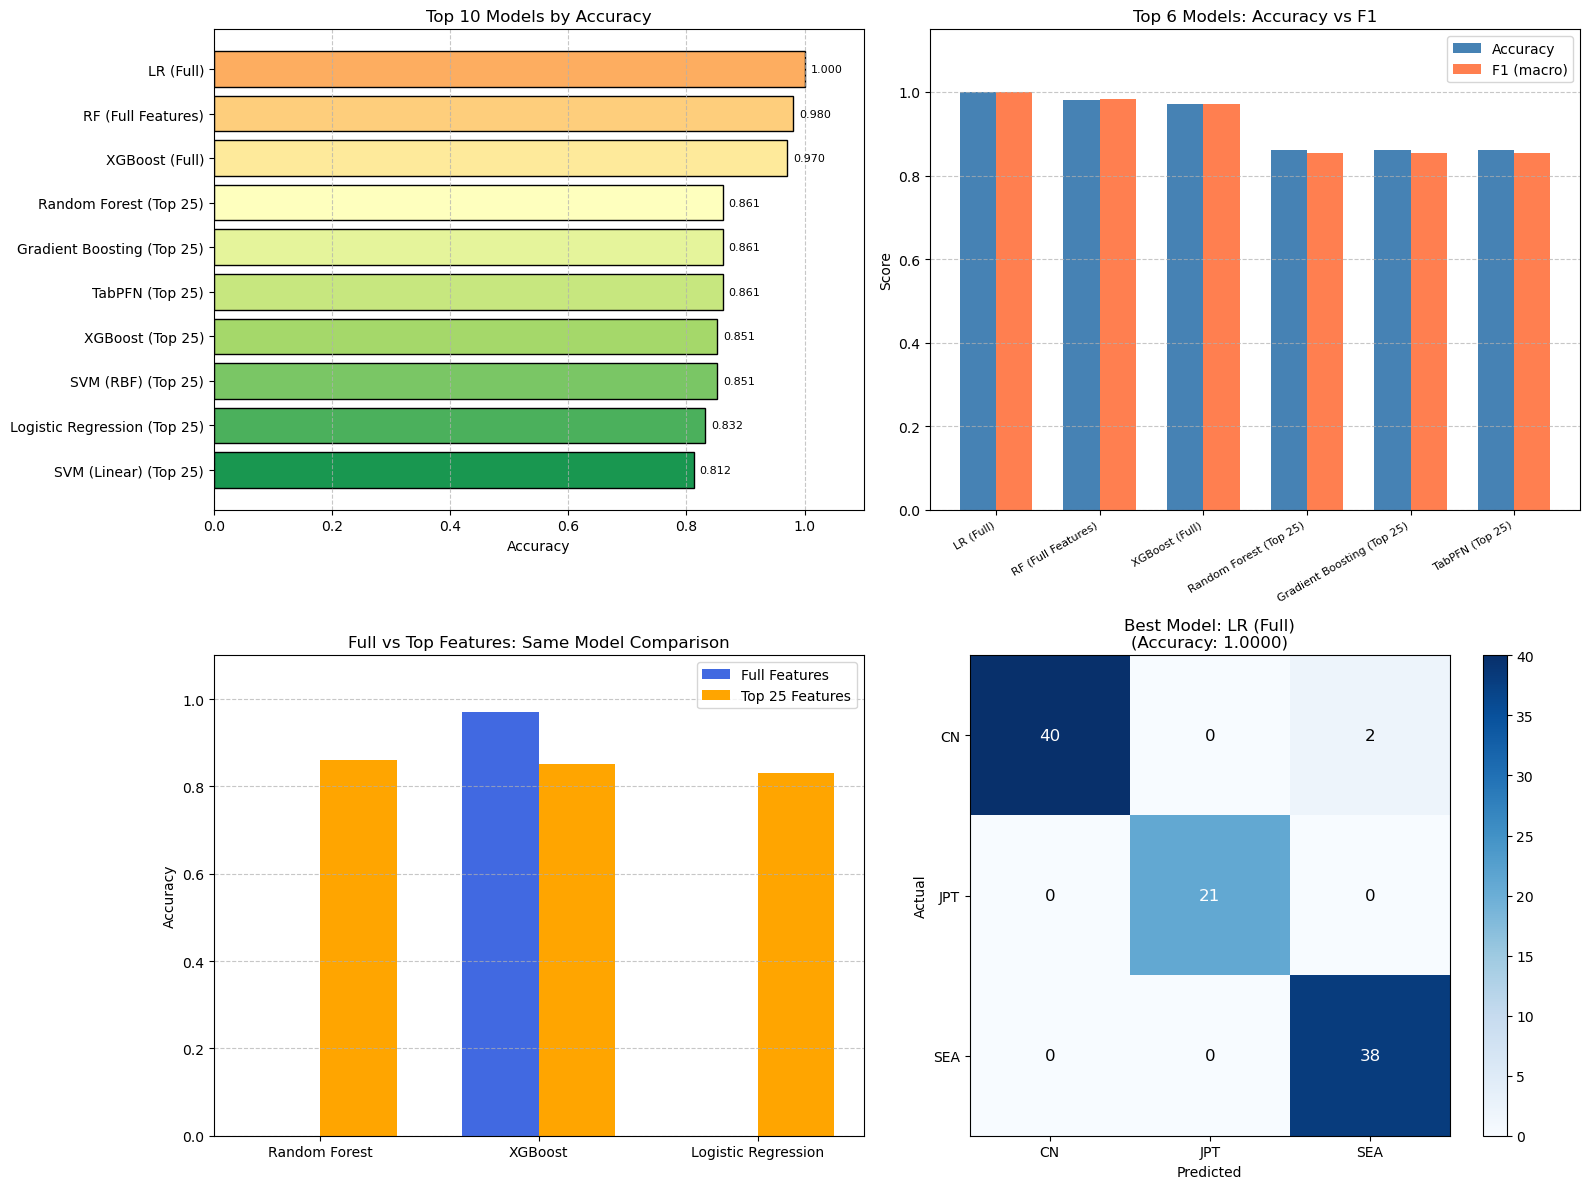


COMPREHENSIVE MODEL COMPARISON SUMMARY
Rank  Model                                    Accuracy     F1 (macro)  
--------------------------------------------------------------------------------
1     LR (Full)                                1.0000       1.0000      
2     RF (Full Features)                       0.9802       0.9833      
3     XGBoost (Full)                           0.9703       0.9713      
4     Random Forest (Top 25)                   0.8614       0.8543      
5     Gradient Boosting (Top 25)               0.8614       0.8543      
6     TabPFN (Top 25)                          0.8614       0.8543      
7     XGBoost (Top 25)                         0.8515       0.8427      
8     SVM (RBF) (Top 25)                       0.8515       0.8401      
9     Logistic Regression (Top 25)             0.8317       0.8144      
10    SVM (Linear) (Top 25)                    0.8119       0.8006      
11    MLP Neural Net (Top 25)                  0.8020       0.7679      
12 

In [60]:
# Comprehensive Model Comparison Chart
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Collect all model results - combine full feature and top feature models
all_models = {
    'RF (Full Features)': rf_results,
    'XGBoost (Full)': xgb_results if xgb_clf is not None else None,
    'LR (Full)': lr_results,
}

# Add top feature model results
for name, result in top_feature_results.items():
    all_models[f'{name} (Top {ML.TOP_N_FEATURES})'] = {
        'accuracy': result['accuracy'],
        'f1_macro': result['f1_macro'],
        'f1_weighted': result['f1_weighted'],
    }

# Add TabPFN if available
if TABPFN_AVAILABLE:
    all_models[f'TabPFN (Top {ML.TOP_N_FEATURES})'] = tabpfn_results

# Remove None entries
all_models = {k: v for k, v in all_models.items() if v is not None}

# Sort by accuracy
sorted_all = sorted(all_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)
model_names = [m[0] for m in sorted_all]
accuracies = [m[1]['accuracy'] for m in sorted_all]
f1_scores = [m[1]['f1_macro'] for m in sorted_all]

# Plot 1: Horizontal bar chart - Top 10 models by accuracy
top_10 = sorted_all[:10]
top_10_names = [m[0] for m in top_10]
top_10_acc = [m[1]['accuracy'] for m in top_10]
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(top_10)))

bars = axes[0, 0].barh(top_10_names[::-1], top_10_acc[::-1], color=colors[::-1], edgecolor='black')
axes[0, 0].set_xlabel('Accuracy')
axes[0, 0].set_title('Top 10 Models by Accuracy')
axes[0, 0].set_xlim(0, 1.1)
axes[0, 0].grid(axis='x', linestyle='--', alpha=0.7)
for bar, acc in zip(bars, top_10_acc[::-1]):
    axes[0, 0].text(acc + 0.01, bar.get_y() + bar.get_height()/2, 
                   f'{acc:.3f}', ha='left', va='center', fontsize=8)

# Plot 2: Grouped bar for top 6 models
top_6 = sorted_all[:6]
x_pos = np.arange(len(top_6))
width = 0.35
top_6_names = [m[0] for m in top_6]
top_6_acc = [m[1]['accuracy'] for m in top_6]
top_6_f1 = [m[1]['f1_macro'] for m in top_6]

bars1 = axes[0, 1].bar(x_pos - width/2, top_6_acc, width, label='Accuracy', color='steelblue')
bars2 = axes[0, 1].bar(x_pos + width/2, top_6_f1, width, label='F1 (macro)', color='coral')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_title('Top 6 Models: Accuracy vs F1')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(top_6_names, rotation=30, ha='right', fontsize=8)
axes[0, 1].legend()
axes[0, 1].set_ylim(0, 1.15)
axes[0, 1].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 3: Full vs Top Features comparison for same model types
model_types = ['Random Forest', 'XGBoost', 'Logistic Regression']
full_acc = []
top_acc = []
for mt in model_types:
    # Find full version
    full_key = [k for k in all_models.keys() if mt in k and 'Full' in k]
    top_key = [k for k in all_models.keys() if mt in k and f'Top {ML.TOP_N_FEATURES}' in k]
    if full_key:
        full_acc.append(all_models[full_key[0]]['accuracy'])
    else:
        full_acc.append(0)
    if top_key:
        top_acc.append(all_models[top_key[0]]['accuracy'])
    else:
        top_acc.append(0)

x = np.arange(len(model_types))
width = 0.35
axes[1, 0].bar(x - width/2, full_acc, width, label='Full Features', color='royalblue')
axes[1, 0].bar(x + width/2, top_acc, width, label=f'Top {ML.TOP_N_FEATURES} Features', color='orange')
axes[1, 0].set_ylabel('Accuracy')
axes[1, 0].set_title('Full vs Top Features: Same Model Comparison')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(model_types)
axes[1, 0].legend()
axes[1, 0].set_ylim(0, 1.1)
axes[1, 0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot 4: Best model confusion matrix
best_name, best_result = sorted_all[0]
if best_name in top_feature_results:
    cm_best = top_feature_results[best_name.replace(f' (Top {ML.TOP_N_FEATURES})', '')]['confusion_matrix']
elif 'TabPFN' in best_name and TABPFN_AVAILABLE:
    cm_best = confusion_matrix(y_test_encoded, tabpfn_results['y_pred'])
else:
    cm_best = cm_full

im = axes[1, 1].imshow(cm_best, cmap='Blues')
axes[1, 1].set_title(f'Best Model: {best_name}\n(Accuracy: {best_result["accuracy"]:.4f})')
axes[1, 1].set_xlabel('Predicted')
axes[1, 1].set_ylabel('Actual')
axes[1, 1].set_xticks(range(len(le.classes_)))
axes[1, 1].set_yticks(range(len(le.classes_)))
axes[1, 1].set_xticklabels(le.classes_)
axes[1, 1].set_yticklabels(le.classes_)
for i in range(len(le.classes_)):
    for j in range(len(le.classes_)):
        axes[1, 1].text(j, i, cm_best[i, j], ha='center', va='center',
                       color='white' if cm_best[i, j] > cm_best.max()/2 else 'black', fontsize=12)
plt.colorbar(im, ax=axes[1, 1])

plt.tight_layout()
plt.show()

# Print comprehensive summary table
print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON SUMMARY")
print("="*80)
print(f"{'Rank':<5} {'Model':<40} {'Accuracy':<12} {'F1 (macro)':<12}")
print("-"*80)
for rank, (name, result) in enumerate(sorted_all[:15], 1):
    print(f"{rank:<5} {name:<40} {result['accuracy']:<12.4f} {result['f1_macro']:<12.4f}")
print("="*80)
print(f"\n🏆 BEST MODEL: {sorted_all[0][0]}")
print(f"   Accuracy: {sorted_all[0][1]['accuracy']:.4f}")
print(f"   F1 (macro): {sorted_all[0][1]['f1_macro']:.4f}")

## Step 8b: Test Multiple Feature Set Sizes (5 to 50 SNPs)

Evaluate model performance across different numbers of top SNPs to find the optimal feature set size.

In [63]:
# Define feature set sizes to test (5 to 50, increment of 5)
feature_sizes = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

# Get ordered list of top features from RF importance
top_features_ordered = rf_importance['feature'].tolist()

# Limit to available features
max_features = min(50, len(top_features_ordered))
feature_sizes = [s for s in feature_sizes if s <= max_features]

print(f"Testing feature set sizes: {feature_sizes}")
print(f"Total available features: {len(top_features_ordered)}")

Testing feature set sizes: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
Total available features: 2518


In [64]:
# Test each feature set size with multiple classifiers
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler

# Select classifiers to test
test_classifiers = {
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=5, learning_rate=0.1, 
                                  random_state=42, n_jobs=-1, verbosity=0),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42, 
                                               multi_class='multinomial', n_jobs=-1),
    'SVM (RBF)': SVC(kernel='rbf', random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, max_depth=5, random_state=42),
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scaler = StandardScaler()

feature_size_results = []

for n_features in feature_sizes:
    print(f"\n{'='*60}")
    print(f"Testing with TOP {n_features} SNPs")
    print(f"{'='*60}")
    
    # Get top N features
    top_n_features = top_features_ordered[:n_features]
    X_reduced = X[top_n_features]
    X_reduced_scaled = scaler.fit_transform(X_reduced)
    
    for clf_name, clf in test_classifiers.items():
        # Clone classifier for fresh training
        clf_clone = clf.__class__(**clf.get_params())
        
        # Use scaled data for SVM and LR
        if 'SVM' in clf_name or 'Logistic' in clf_name:
            X_use = X_reduced_scaled
        else:
            X_use = X_reduced.values
        
        # Use encoded labels for XGBoost
        if 'XGBoost' in clf_name:
            y_use = y_encoded
        else:
            y_use = y
        
        try:
            cv_scores = cross_val_score(clf_clone, X_use, y_use, cv=cv, scoring='accuracy')
            feature_size_results.append({
                'N_Features': n_features,
                'Model': clf_name,
                'Accuracy_Mean': cv_scores.mean(),
                'Accuracy_Std': cv_scores.std()
            })
            print(f"  {clf_name}: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")
        except Exception as e:
            print(f"  {clf_name}: Error - {e}")
            feature_size_results.append({
                'N_Features': n_features,
                'Model': clf_name,
                'Accuracy_Mean': np.nan,
                'Accuracy_Std': np.nan
            })

feature_size_df = pd.DataFrame(feature_size_results)
print("\n" + "="*60)
print("Feature size testing complete!")


Testing with TOP 5 SNPs
  Random Forest: 0.6825 ± 0.0145
  XGBoost: 0.6845 ± 0.0190


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Logistic Regression: 0.6884 ± 0.0222
  SVM (RBF): 0.6786 ± 0.0175
  Gradient Boosting: 0.6765 ± 0.0230

Testing with TOP 10 SNPs
  Random Forest: 0.7759 ± 0.0395
  XGBoost: 0.7619 ± 0.0318


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Logistic Regression: 0.7619 ± 0.0213
  SVM (RBF): 0.7858 ± 0.0311
  Gradient Boosting: 0.7659 ± 0.0371

Testing with TOP 15 SNPs
  Random Forest: 0.8135 ± 0.0381
  XGBoost: 0.8095 ± 0.0394
  Logistic Regression: 0.8016 ± 0.0476
  SVM (RBF): 0.8055 ± 0.0271


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.7976 ± 0.0420

Testing with TOP 20 SNPs
  Random Forest: 0.8313 ± 0.0360
  XGBoost: 0.8234 ± 0.0389
  Logistic Regression: 0.8254 ± 0.0253
  SVM (RBF): 0.8333 ± 0.0254


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8055 ± 0.0349

Testing with TOP 25 SNPs
  Random Forest: 0.8690 ± 0.0390
  XGBoost: 0.8750 ± 0.0401
  Logistic Regression: 0.8730 ± 0.0346
  SVM (RBF): 0.8809 ± 0.0421


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8511 ± 0.0384

Testing with TOP 30 SNPs
  Random Forest: 0.8968 ± 0.0371
  XGBoost: 0.8928 ± 0.0313
  Logistic Regression: 0.8928 ± 0.0233
  SVM (RBF): 0.9146 ± 0.0314


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8908 ± 0.0346

Testing with TOP 35 SNPs
  Random Forest: 0.8968 ± 0.0402
  XGBoost: 0.8987 ± 0.0300
  Logistic Regression: 0.9008 ± 0.0259
  SVM (RBF): 0.9106 ± 0.0329


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8967 ± 0.0367

Testing with TOP 40 SNPs
  Random Forest: 0.9107 ± 0.0234
  XGBoost: 0.9086 ± 0.0307
  Logistic Regression: 0.9107 ± 0.0219
  SVM (RBF): 0.9167 ± 0.0270


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8888 ± 0.0258

Testing with TOP 45 SNPs
  Random Forest: 0.9107 ± 0.0109
  XGBoost: 0.9067 ± 0.0226
  Logistic Regression: 0.9166 ± 0.0176
  SVM (RBF): 0.9246 ± 0.0240


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8987 ± 0.0287

Testing with TOP 50 SNPs
  Random Forest: 0.9345 ± 0.0050
  XGBoost: 0.9047 ± 0.0207
  Logistic Regression: 0.9266 ± 0.0203
  SVM (RBF): 0.9445 ± 0.0204


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/home/Plutonium/minifo

  Gradient Boosting: 0.8968 ± 0.0255

Feature size testing complete!


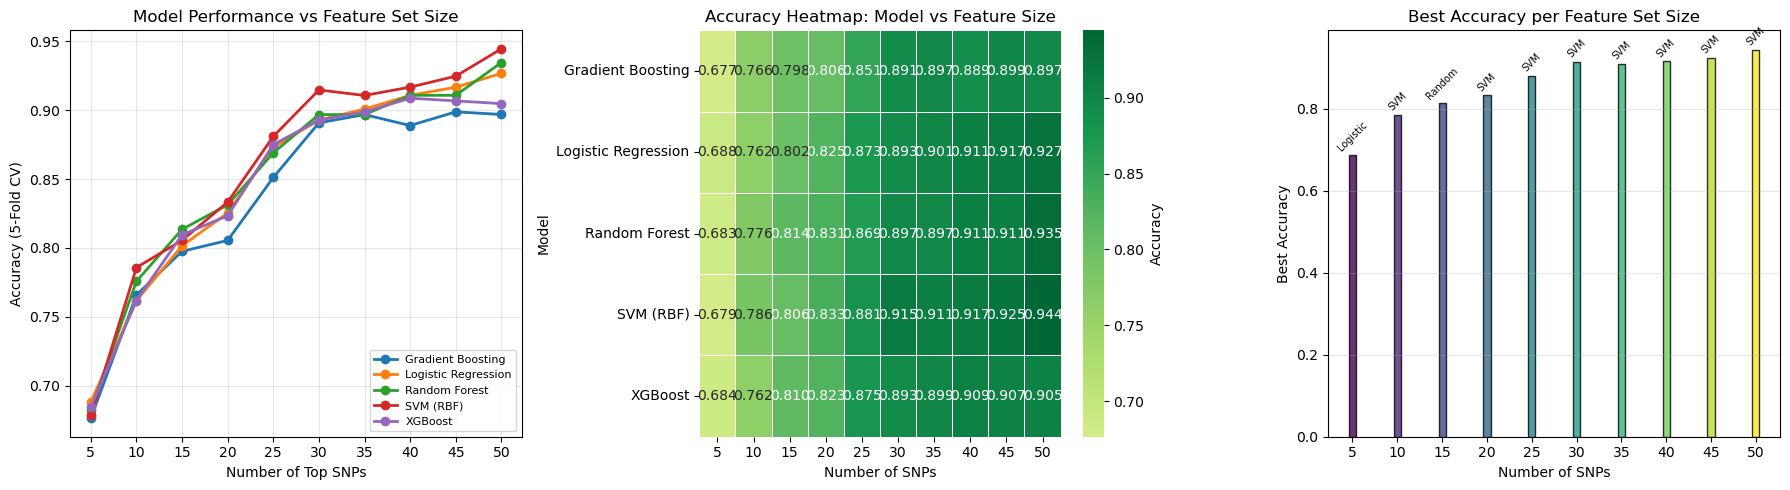


Best Model per Feature Size:
   5 SNPs: Logistic Regression  (0.6884 ± 0.0222)
  10 SNPs: SVM (RBF)            (0.7858 ± 0.0311)
  15 SNPs: Random Forest        (0.8135 ± 0.0381)
  20 SNPs: SVM (RBF)            (0.8333 ± 0.0254)
  25 SNPs: SVM (RBF)            (0.8809 ± 0.0421)
  30 SNPs: SVM (RBF)            (0.9146 ± 0.0314)
  35 SNPs: SVM (RBF)            (0.9106 ± 0.0329)
  40 SNPs: SVM (RBF)            (0.9167 ± 0.0270)
  45 SNPs: SVM (RBF)            (0.9246 ± 0.0240)
  50 SNPs: SVM (RBF)            (0.9445 ± 0.0204)

Results saved to: output/ml_models/sea_jpt_cn/feature_size_results.csv


In [65]:
# Visualize feature size vs accuracy
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Pivot table for heatmap
pivot_df = feature_size_df.pivot(index='Model', columns='N_Features', values='Accuracy_Mean')

# Plot 1: Line plot - Accuracy vs Feature Size by Model
ax = axes[0]
for model in pivot_df.index:
    ax.plot(feature_sizes, pivot_df.loc[model].values, 'o-', label=model, linewidth=2, markersize=6)
ax.set_xlabel('Number of Top SNPs')
ax.set_ylabel('Accuracy (5-Fold CV)')
ax.set_title('Model Performance vs Feature Set Size')
ax.legend(loc='lower right', fontsize=8)
ax.grid(True, alpha=0.3)
ax.set_xticks(feature_sizes)

# Plot 2: Heatmap
ax = axes[1]
sns.heatmap(pivot_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0.6,
            linewidths=0.5, ax=ax, cbar_kws={'label': 'Accuracy'})
ax.set_title('Accuracy Heatmap: Model vs Feature Size')
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Model')

# Plot 3: Best model per feature size
ax = axes[2]
best_per_size = feature_size_df.loc[feature_size_df.groupby('N_Features')['Accuracy_Mean'].idxmax()]
colors = plt.cm.viridis(np.linspace(0, 1, len(best_per_size)))
bars = ax.bar(best_per_size['N_Features'], best_per_size['Accuracy_Mean'], 
              color=colors, edgecolor='black', alpha=0.8)
ax.set_xlabel('Number of SNPs')
ax.set_ylabel('Best Accuracy')
ax.set_title('Best Accuracy per Feature Set Size')
ax.set_xticks(feature_sizes)
ax.grid(True, alpha=0.3, axis='y')

# Add model names on bars
for bar, model in zip(bars, best_per_size['Model']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
            model.split()[0], ha='center', va='bottom', fontsize=7, rotation=45)

plt.tight_layout()
plt.savefig(str(output_dir / 'feature_size_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

# Print summary table
print("\nBest Model per Feature Size:")
print("="*60)
for _, row in best_per_size.iterrows():
    print(f"  {int(row['N_Features']):2d} SNPs: {row['Model']:<20} ({row['Accuracy_Mean']:.4f} ± {row['Accuracy_Std']:.4f})")

# Save results
feature_size_df.to_csv(str(output_dir / 'feature_size_results.csv'), index=False)
pivot_df.to_csv(str(output_dir / 'feature_size_pivot.csv'))
print(f"\nResults saved to: {output_dir / 'feature_size_results.csv'}")

## Step 8c: TabPFN Evaluation on 25-50 Top SNPs

TabPFN is a transformer-based model optimized for small tabular datasets. Test it across feature sizes from 25 to 50 SNPs.

In [66]:
# TabPFN evaluation on 25-50 SNPs
if TABPFN_AVAILABLE:
    from tabpfn import TabPFNClassifier
    
    # Feature sizes for TabPFN (25 to 50)
    tabpfn_feature_sizes = [25, 30, 35, 40, 45, 50]
    tabpfn_feature_sizes = [s for s in tabpfn_feature_sizes if s <= max_features]
    
    tabpfn_results_list = []
    
    print("Testing TabPFN across feature sizes (25-50 SNPs)...")
    print("="*60)
    
    for n_features in tabpfn_feature_sizes:
        print(f"\n>>> TabPFN with {n_features} SNPs...")
        
        # Get top N features
        top_n_features = top_features_ordered[:n_features]
        X_reduced = X[top_n_features]
        
        # 5-Fold CV for TabPFN
        cv_scores_tabpfn = []
        
        for train_idx, val_idx in cv.split(X_reduced, y):
            try:
                tabpfn_cv = TabPFNClassifier(device='cpu', n_estimators=4)
                X_train_cv = X_reduced.values[train_idx]
                y_train_cv = y_encoded[train_idx]
                X_val_cv = X_reduced.values[val_idx]
                y_val_cv = y_encoded[val_idx]
                
                tabpfn_cv.fit(X_train_cv, y_train_cv)
                y_pred_cv = tabpfn_cv.predict(X_val_cv)
                
                from sklearn.metrics import accuracy_score
                cv_scores_tabpfn.append(accuracy_score(y_val_cv, y_pred_cv))
            except Exception as e:
                print(f"    Fold error: {e}")
                cv_scores_tabpfn.append(np.nan)
        
        mean_acc = np.nanmean(cv_scores_tabpfn)
        std_acc = np.nanstd(cv_scores_tabpfn)
        
        tabpfn_results_list.append({
            'N_Features': n_features,
            'Model': 'TabPFN',
            'Accuracy_Mean': mean_acc,
            'Accuracy_Std': std_acc
        })
        
        print(f"    Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")
    
    tabpfn_df = pd.DataFrame(tabpfn_results_list)
    print("\n" + "="*60)
    print("TabPFN testing complete!")
else:
    print("TabPFN not available. Install with: pip install tabpfn")
    tabpfn_df = pd.DataFrame()

Testing TabPFN across feature sizes (25-50 SNPs)...

>>> TabPFN with 25 SNPs...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with mo

    Accuracy: 0.8810 ± 0.0420

>>> TabPFN with 30 SNPs...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with mo

    Accuracy: 0.9106 ± 0.0390

>>> TabPFN with 35 SNPs...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with mo

    Accuracy: 0.9146 ± 0.0280

>>> TabPFN with 40 SNPs...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with mo

    Accuracy: 0.9265 ± 0.0336

>>> TabPFN with 45 SNPs...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with mo

    Accuracy: 0.9285 ± 0.0286

>>> TabPFN with 50 SNPs...


/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with more than 200 samples may be slow.
Consider using a GPU or the tabpfn-client API: https://github.com/PriorLabs/tabpfn-client
  check_cpu_warning(
/home/Plutonium/miniforge3/envs/GeneAnalysisET4596E/lib/python3.10/site-packages/tabpfn/classifier.py:459: UserWarning: Running on CPU with mo

    Accuracy: 0.9524 ± 0.0212

TabPFN testing complete!


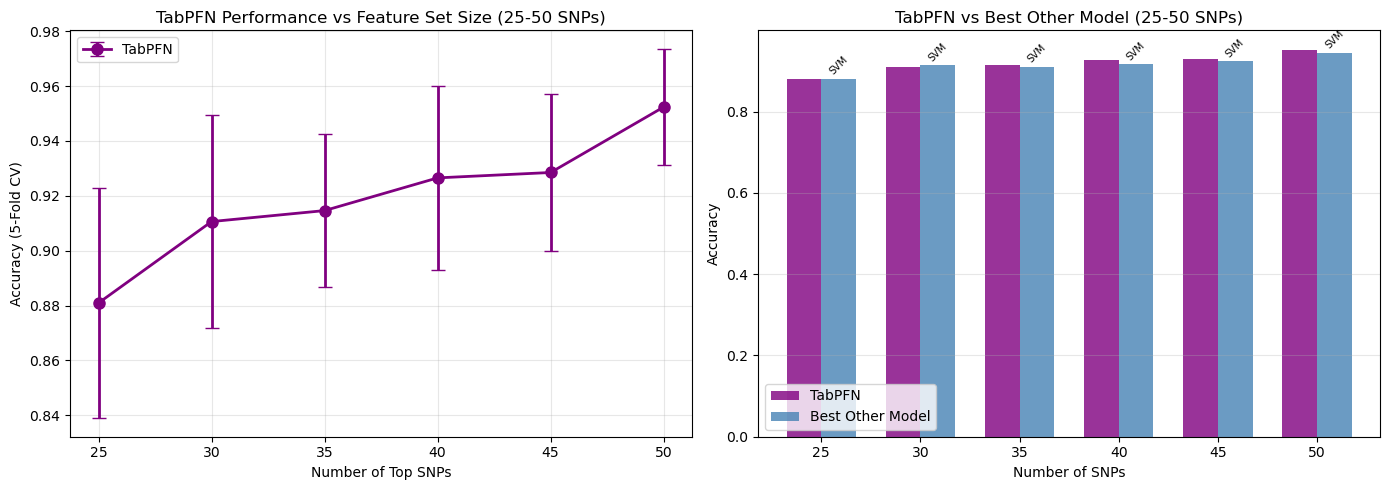


TabPFN Results Summary (25-50 SNPs):
  25 SNPs: 0.8810 ± 0.0420
  30 SNPs: 0.9106 ± 0.0390
  35 SNPs: 0.9146 ± 0.0280
  40 SNPs: 0.9265 ± 0.0336
  45 SNPs: 0.9285 ± 0.0286
  50 SNPs: 0.9524 ± 0.0212

★ Best TabPFN: 50 SNPs (0.9524)

TabPFN results saved to: output/ml_models/sea_jpt_cn/tabpfn_feature_size_results.csv


In [67]:
# Visualize TabPFN results and compare with other models
if TABPFN_AVAILABLE and len(tabpfn_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Plot 1: TabPFN accuracy vs feature size
    ax = axes[0]
    ax.errorbar(tabpfn_df['N_Features'], tabpfn_df['Accuracy_Mean'], 
                yerr=tabpfn_df['Accuracy_Std'], fmt='o-', linewidth=2, 
                markersize=8, capsize=5, color='purple', label='TabPFN')
    ax.set_xlabel('Number of Top SNPs')
    ax.set_ylabel('Accuracy (5-Fold CV)')
    ax.set_title('TabPFN Performance vs Feature Set Size (25-50 SNPs)')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(tabpfn_feature_sizes)
    ax.legend()
    
    # Plot 2: Compare TabPFN with best other model at each size
    ax = axes[1]
    
    # Get best non-TabPFN model for sizes 25-50
    comparison_sizes = [s for s in tabpfn_feature_sizes if s in feature_sizes]
    best_other = feature_size_df[feature_size_df['N_Features'].isin(comparison_sizes)]
    best_other = best_other.loc[best_other.groupby('N_Features')['Accuracy_Mean'].idxmax()]
    
    x = np.arange(len(comparison_sizes))
    width = 0.35
    
    tabpfn_acc = tabpfn_df[tabpfn_df['N_Features'].isin(comparison_sizes)]['Accuracy_Mean'].values
    other_acc = best_other['Accuracy_Mean'].values
    other_models = best_other['Model'].values
    
    bars1 = ax.bar(x - width/2, tabpfn_acc, width, label='TabPFN', color='purple', alpha=0.8)
    bars2 = ax.bar(x + width/2, other_acc, width, label='Best Other Model', color='steelblue', alpha=0.8)
    
    ax.set_xlabel('Number of SNPs')
    ax.set_ylabel('Accuracy')
    ax.set_title('TabPFN vs Best Other Model (25-50 SNPs)')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_sizes)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add model names on bars
    for bar, model in zip(bars2, other_models):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                model.split()[0], ha='center', va='bottom', fontsize=7, rotation=45)
    
    plt.tight_layout()
    plt.savefig(str(output_dir / 'tabpfn_feature_size_comparison.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print summary
    print("\nTabPFN Results Summary (25-50 SNPs):")
    print("="*60)
    for _, row in tabpfn_df.iterrows():
        print(f"  {int(row['N_Features']):2d} SNPs: {row['Accuracy_Mean']:.4f} ± {row['Accuracy_Std']:.4f}")
    
    # Find best TabPFN configuration
    best_tabpfn = tabpfn_df.loc[tabpfn_df['Accuracy_Mean'].idxmax()]
    print(f"\n★ Best TabPFN: {int(best_tabpfn['N_Features'])} SNPs ({best_tabpfn['Accuracy_Mean']:.4f})")
    
    # Save TabPFN results
    tabpfn_df.to_csv(str(output_dir / 'tabpfn_feature_size_results.csv'), index=False)
    print(f"\nTabPFN results saved to: {output_dir / 'tabpfn_feature_size_results.csv'}")

## Step 9: Save Models

In [61]:
# Create output directory
output_dir = ensure_dir(PATHS.ML_MODELS_DIR)

# Save full feature models
save_model(
    rf, output_dir / "random_forest_full.pkl",
    metadata={"n_features": len(feature_names), "accuracy": rf_results["accuracy"]},
)

save_model(
    lr, output_dir / "logistic_regression_full.pkl",
    metadata={"accuracy": lr_results["accuracy"]},
)

if xgb_clf is not None:
    save_model(
        xgb_clf, output_dir / "xgboost_full.pkl",
        metadata={"accuracy": xgb_results["accuracy"]},
    )

# Save top feature models
for name, result in top_feature_results.items():
    safe_name = name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    save_model(
        result['model'], output_dir / f"{safe_name}_top{ML.TOP_N_FEATURES}.pkl",
        metadata={"n_features": ML.TOP_N_FEATURES, "accuracy": result["accuracy"]},
    )

# Save TabPFN if available
if TABPFN_AVAILABLE:
    save_model(
        tabpfn, output_dir / f"tabpfn_top{ML.TOP_N_FEATURES}.pkl",
        metadata={"n_features": ML.TOP_N_FEATURES, "accuracy": tabpfn_results["accuracy"]},
    )

# Save feature importance
rf_importance.to_csv(output_dir / "feature_importances.csv", index=False)

# Save top features list
top_feature_df = rf_importance.head(ML.TOP_N_FEATURES)
top_feature_df.to_csv(output_dir / f"top_{ML.TOP_N_FEATURES}_features.csv", index=False)

# Save comprehensive model comparison results
comparison_results = pd.DataFrame([
    {"model": k, "accuracy": v["accuracy"], "f1_macro": v["f1_macro"]}
    for k, v in sorted(all_models.items(), key=lambda x: x[1]['accuracy'], reverse=True)
])
comparison_results.to_csv(output_dir / "model_comparison.csv", index=False)

print(f"\nAll models saved to: {output_dir}")
print(f"\nFull Feature Models:")
print(f"  - random_forest_full.pkl")
print(f"  - logistic_regression_full.pkl")
if xgb_clf is not None:
    print(f"  - xgboost_full.pkl")
print(f"\nTop {ML.TOP_N_FEATURES} Feature Models:")
for name in top_feature_results.keys():
    safe_name = name.lower().replace(' ', '_').replace('(', '').replace(')', '')
    print(f"  - {safe_name}_top{ML.TOP_N_FEATURES}.pkl")
if TABPFN_AVAILABLE:
    print(f"  - tabpfn_top{ML.TOP_N_FEATURES}.pkl")
print(f"\nData Files:")
print(f"  - feature_importances.csv")
print(f"  - top_{ML.TOP_N_FEATURES}_features.csv")
print(f"  - model_comparison.csv")

Model saved to: output/ml_models/sea_jpt_cn/random_forest_full.pkl
Model saved to: output/ml_models/sea_jpt_cn/logistic_regression_full.pkl
Model saved to: output/ml_models/sea_jpt_cn/xgboost_full.pkl
Model saved to: output/ml_models/sea_jpt_cn/random_forest_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/xgboost_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/logistic_regression_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/svm_rbf_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/svm_linear_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/k-nearest_neighbors_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/naive_bayes_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/gradient_boosting_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/adaboost_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/mlp_neural_net_top25.pkl
Model saved to: output/ml_models/sea_jpt_cn/tabpfn_top25.pkl

All models saved to: output/ml_models/sea_jpt_cn

Full Feature

## Summary

In [62]:
# Find best model from all trained models
best_model_name, best_model_result = sorted_all[0]

print("="*70)
print("ML TRAINING SUMMARY")
print("="*70)
print(f"\nData:")
print(f"  Total Samples: {len(X)}")
print(f"  Total Features: {len(feature_names)}")
print(f"  Top Features Used: {ML.TOP_N_FEATURES}")
print(f"  Classes: {len(le.classes_)} ({list(le.classes_)})")
print(f"\nModels Trained: {len(all_models)}")
print(f"  Full Feature Models: 3 (RF, XGBoost, LR)")
print(f"  Top Feature Models: {len(top_feature_results)} + TabPFN")

print(f"\n🏆 Best Model: {best_model_name}")
print(f"   Accuracy: {best_model_result['accuracy']:.4f}")
print(f"   F1 (macro): {best_model_result['f1_macro']:.4f}")

print(f"\nTop 5 Models:")
for rank, (name, result) in enumerate(sorted_all[:5], 1):
    print(f"  {rank}. {name}: {result['accuracy']:.4f}")

print(f"\nModels saved to: {output_dir}")
print(f"\nNext step: Run 05_model_evaluation.ipynb for detailed analysis")

ML TRAINING SUMMARY

Data:
  Total Samples: 504
  Total Features: 2518
  Top Features Used: 25
  Classes: 3 (['CN', 'JPT', 'SEA'])

Models Trained: 14
  Full Feature Models: 3 (RF, XGBoost, LR)
  Top Feature Models: 10 + TabPFN

🏆 Best Model: LR (Full)
   Accuracy: 1.0000
   F1 (macro): 1.0000

Top 5 Models:
  1. LR (Full): 1.0000
  2. RF (Full Features): 0.9802
  3. XGBoost (Full): 0.9703
  4. Random Forest (Top 25): 0.8614
  5. Gradient Boosting (Top 25): 0.8614

Models saved to: output/ml_models/sea_jpt_cn

Next step: Run 05_model_evaluation.ipynb for detailed analysis
